# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory 'data': File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:12, 14.6MB/s]                              
SVHN Testing Set: 64.3MB [00:04, 15.1MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

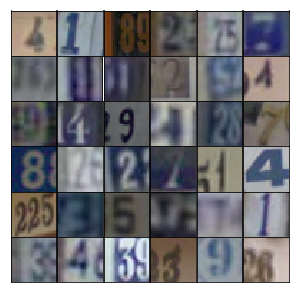

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=False, sharey=False, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
a = np.reshape(np.arange(12), [3,4])

In [8]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

### 转置坐标系

In [9]:
np.rollaxis(a, 1)

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [10]:
np.moveaxis(a, 1, 0)

array([[ 0,  4,  8],
       [ 1,  5,  9],
       [ 2,  6, 10],
       [ 3,  7, 11]])

In [11]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [12]:
def model_inputs(real_dim, z_dim):
    with tf.name_scope('input'):
        # real_dim = 32*32*3
        inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
        inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [13]:
def leaky_relus(x, alpha=0.2):
    return tf.maximum(x*alpha, x)

In [14]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        project = tf.layers.dense(z, 2*2*1024, use_bias=False,activation=None, name='project')
        reshape = tf.reshape(project,[-1, 2, 2, 1024], name='reshape')
        x = tf.layers.batch_normalization(reshape, training=training)
        conv1 = tf.identity(leaky_relus(x, alpha), name='conv1')
        #now 2*2*1024
        
        conv2 = tf.layers.conv2d_transpose(conv1, 512, 2, strides=(2,2), padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.identity(leaky_relus(conv2, alpha), name='conv2')
        #now 4*4*512
        
        conv3 = tf.layers.conv2d_transpose(conv2, 256, 5, strides=(2,2), padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=training)
        conv3 = tf.identity(leaky_relus(conv3, alpha), name='conv3')
        #now 8*8*256
        
        conv4 = tf.layers.conv2d_transpose(conv3, 128, 5, strides=(2,2), padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=training)
        conv4 = tf.identity(leaky_relus(conv4,alpha), name='conv4')
        #now 16*16*128
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(conv4, output_dim, 5, strides=(2,2), padding='same', name='logits')
        
        out = tf.tanh(logits, name='out')
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [15]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 16, 5, strides=2, padding='same')
#         x = tf.layers.batch_normalization(x, training=True)
        x = tf.identity(leaky_relus(x, alpha), name='conv1')
        #now 16*16*16
        
        conv2 = tf.layers.conv2d(x, 32, 5, strides=2, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.identity(leaky_relus(conv2, alpha), name='conv2')
        #now 8*8*32
        
        conv3 = tf.layers.conv2d(conv2, 64, 5, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.identity(leaky_relus(conv3, alpha), name='conv3')
        #now 4*4*64
        
        conv4 = tf.layers.conv2d(conv3, 128, 5, strides=2, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=True)
        conv4 = tf.identity(leaky_relus(conv4, alpha), name='conv4')
        #now 2*2*128
        
#         conv4 = tf.reshape(conv4, [-1, 2*2*128])
        logits = tf.layers.dense(conv4, 1, name='logits')
        out = tf.nn.sigmoid(logits, name='out')
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [16]:
def model_loss(input_real, input_z, output_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    with tf.name_scope('loss'):
        g_model = generator(input_z, output_dim, alpha=alpha)
        d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
        d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

        d_loss_real = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
        d_loss_fake = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
        g_loss = tf.reduce_mean(
            tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

        d_loss = d_loss_real + d_loss_fake
        
        tf.summary.scalar('d_loss_real', d_loss_real)
        tf.summary.scalar('d_loss_fake', d_loss_fake)
        tf.summary.scalar('d_loss', d_loss)
        tf.summary.scalar('g_loss',g_loss)

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.name_scope('optimization'):
        # Optimize
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
            g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [18]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
        self.summary = tf.summary.merge_all()

Here is a function for displaying generated images.

In [19]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [20]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5),writer_dis=None,writer_gen=None):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _,d_summary = sess.run([net.d_opt, net.summary], feed_dict={net.input_real: x, net.input_z: batch_z})
                _,g_summary = sess.run([net.g_opt, net.summary], feed_dict={net.input_z: batch_z, net.input_real: x})
                if writer_dis != None:
                    writer_dis.add_summary(d_summary, steps)
                if writer_gen != None:
                    writer_gen.add_summary(g_summary, steps)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [21]:
tensorboard = '/tmp/dcgan/'

In [24]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.001
batch_size = 256
epochs = 20
alpha = 0.01
beta1 = 0.9

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)
writer_discriminator = tf.summary.FileWriter(tensorboard+'discriminator',graph=tf.get_default_graph())
writer_generator = tf.summary.FileWriter(tensorboard+'generator')

Epoch 1/20... Discriminator Loss: 1.0076... Generator Loss: 1.1325
Epoch 1/20... Discriminator Loss: 0.6951... Generator Loss: 1.5793
Epoch 1/20... Discriminator Loss: 0.5678... Generator Loss: 1.8938
Epoch 1/20... Discriminator Loss: 0.5937... Generator Loss: 1.8005
Epoch 1/20... Discriminator Loss: 0.5392... Generator Loss: 2.0427
Epoch 1/20... Discriminator Loss: 0.4559... Generator Loss: 2.4849
Epoch 1/20... Discriminator Loss: 0.4181... Generator Loss: 2.7674
Epoch 1/20... Discriminator Loss: 0.3894... Generator Loss: 2.9643
Epoch 1/20... Discriminator Loss: 0.3952... Generator Loss: 2.9911
Epoch 1/20... Discriminator Loss: 0.3855... Generator Loss: 3.0159


/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


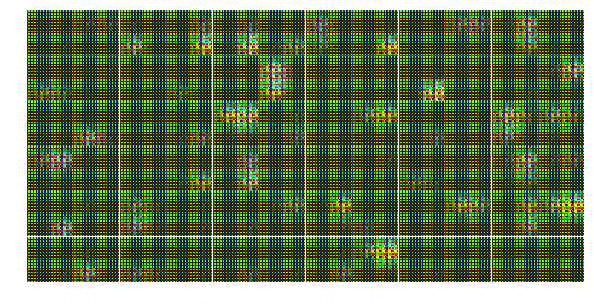

Epoch 1/20... Discriminator Loss: 0.3794... Generator Loss: 3.2292
Epoch 1/20... Discriminator Loss: 0.3683... Generator Loss: 3.3751
Epoch 1/20... Discriminator Loss: 0.3641... Generator Loss: 3.5212
Epoch 1/20... Discriminator Loss: 0.3554... Generator Loss: 3.5758
Epoch 1/20... Discriminator Loss: 0.3545... Generator Loss: 3.7049
Epoch 1/20... Discriminator Loss: 0.3522... Generator Loss: 3.8661
Epoch 1/20... Discriminator Loss: 0.3460... Generator Loss: 4.0017
Epoch 1/20... Discriminator Loss: 0.3438... Generator Loss: 4.1737
Epoch 1/20... Discriminator Loss: 0.3447... Generator Loss: 4.2550
Epoch 1/20... Discriminator Loss: 0.3409... Generator Loss: 4.2886


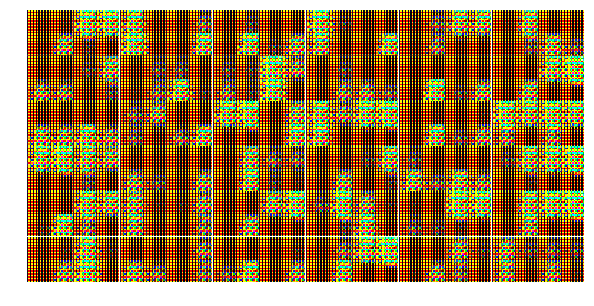

Epoch 1/20... Discriminator Loss: 0.3403... Generator Loss: 4.3802
Epoch 1/20... Discriminator Loss: 0.3493... Generator Loss: 4.4692
Epoch 1/20... Discriminator Loss: 0.3393... Generator Loss: 4.4947
Epoch 1/20... Discriminator Loss: 0.3374... Generator Loss: 4.5104
Epoch 1/20... Discriminator Loss: 0.3423... Generator Loss: 4.2664
Epoch 1/20... Discriminator Loss: 0.3461... Generator Loss: 4.0981
Epoch 1/20... Discriminator Loss: 0.3427... Generator Loss: 4.3541
Epoch 1/20... Discriminator Loss: 0.3429... Generator Loss: 4.5703
Epoch 2/20... Discriminator Loss: 0.3396... Generator Loss: 4.4917
Epoch 2/20... Discriminator Loss: 0.3473... Generator Loss: 4.0033


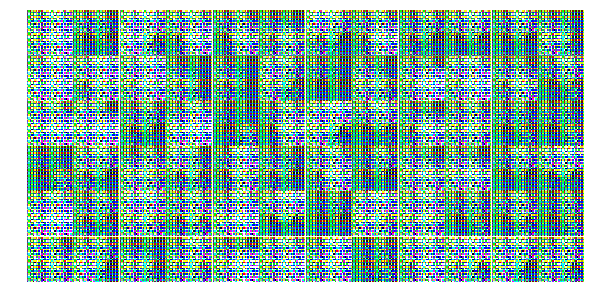

Epoch 2/20... Discriminator Loss: 0.3367... Generator Loss: 4.8429
Epoch 2/20... Discriminator Loss: 0.3353... Generator Loss: 4.8884
Epoch 2/20... Discriminator Loss: 0.3335... Generator Loss: 5.0514
Epoch 2/20... Discriminator Loss: 0.3319... Generator Loss: 5.1970
Epoch 2/20... Discriminator Loss: 0.3318... Generator Loss: 5.2227
Epoch 2/20... Discriminator Loss: 0.3318... Generator Loss: 5.2088
Epoch 2/20... Discriminator Loss: 0.3329... Generator Loss: 5.2128
Epoch 2/20... Discriminator Loss: 0.3329... Generator Loss: 5.3473
Epoch 2/20... Discriminator Loss: 0.3317... Generator Loss: 5.3959
Epoch 2/20... Discriminator Loss: 0.3306... Generator Loss: 5.4701


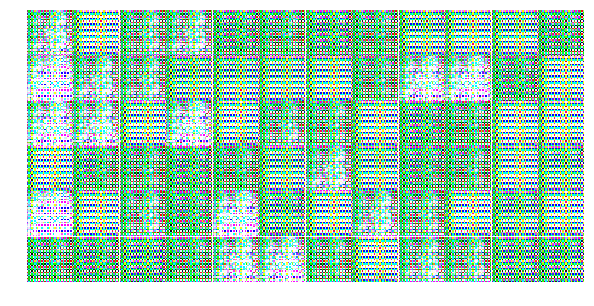

Epoch 2/20... Discriminator Loss: 0.3314... Generator Loss: 5.4686
Epoch 2/20... Discriminator Loss: 0.3308... Generator Loss: 5.4889
Epoch 2/20... Discriminator Loss: 0.3333... Generator Loss: 5.0656
Epoch 2/20... Discriminator Loss: 0.5369... Generator Loss: 1.7068
Epoch 2/20... Discriminator Loss: 0.3777... Generator Loss: 3.3753
Epoch 2/20... Discriminator Loss: 0.3730... Generator Loss: 3.8101
Epoch 2/20... Discriminator Loss: 0.3483... Generator Loss: 4.5453
Epoch 2/20... Discriminator Loss: 0.3354... Generator Loss: 5.2891
Epoch 2/20... Discriminator Loss: 0.3333... Generator Loss: 5.3330
Epoch 2/20... Discriminator Loss: 0.3351... Generator Loss: 5.4257


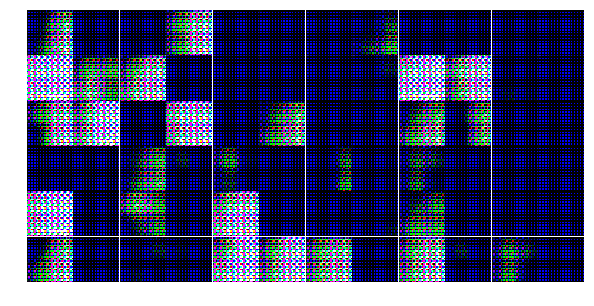

Epoch 2/20... Discriminator Loss: 0.3326... Generator Loss: 5.4266
Epoch 2/20... Discriminator Loss: 0.3314... Generator Loss: 5.4953
Epoch 2/20... Discriminator Loss: 0.3344... Generator Loss: 5.6058
Epoch 2/20... Discriminator Loss: 0.3355... Generator Loss: 4.9001
Epoch 2/20... Discriminator Loss: 0.3320... Generator Loss: 5.7560
Epoch 2/20... Discriminator Loss: 0.3302... Generator Loss: 5.7397
Epoch 2/20... Discriminator Loss: 0.3289... Generator Loss: 5.8733
Epoch 3/20... Discriminator Loss: 0.3349... Generator Loss: 5.8898
Epoch 3/20... Discriminator Loss: 0.3288... Generator Loss: 5.9700
Epoch 3/20... Discriminator Loss: 0.3291... Generator Loss: 5.8556


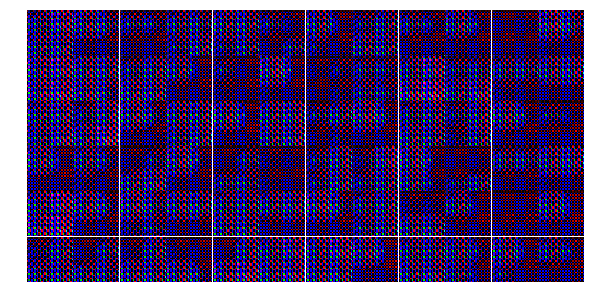

Epoch 3/20... Discriminator Loss: 0.3318... Generator Loss: 5.9017
Epoch 3/20... Discriminator Loss: 0.3291... Generator Loss: 6.1268
Epoch 3/20... Discriminator Loss: 0.3289... Generator Loss: 6.1783
Epoch 3/20... Discriminator Loss: 0.3287... Generator Loss: 6.2204
Epoch 3/20... Discriminator Loss: 0.3277... Generator Loss: 6.2894
Epoch 3/20... Discriminator Loss: 0.3284... Generator Loss: 6.3487
Epoch 3/20... Discriminator Loss: 0.3273... Generator Loss: 6.3612
Epoch 3/20... Discriminator Loss: 0.3275... Generator Loss: 6.4040
Epoch 3/20... Discriminator Loss: 0.3271... Generator Loss: 6.4489
Epoch 3/20... Discriminator Loss: 0.3272... Generator Loss: 6.4989


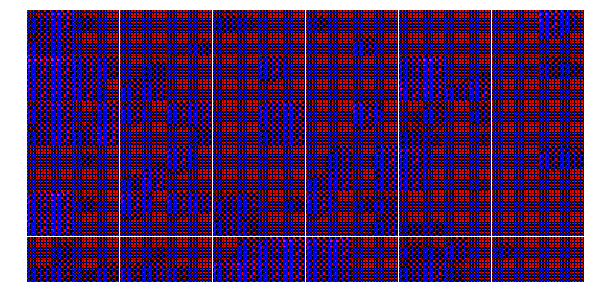

Epoch 3/20... Discriminator Loss: 0.3275... Generator Loss: 6.5110
Epoch 3/20... Discriminator Loss: 0.3275... Generator Loss: 6.5350
Epoch 3/20... Discriminator Loss: 0.3275... Generator Loss: 6.5870
Epoch 3/20... Discriminator Loss: 0.3273... Generator Loss: 6.5628
Epoch 3/20... Discriminator Loss: 0.3271... Generator Loss: 6.5621
Epoch 3/20... Discriminator Loss: 0.3273... Generator Loss: 6.5997
Epoch 3/20... Discriminator Loss: 0.3293... Generator Loss: 6.6257
Epoch 3/20... Discriminator Loss: 0.3278... Generator Loss: 6.6935
Epoch 3/20... Discriminator Loss: 0.3274... Generator Loss: 6.7018
Epoch 3/20... Discriminator Loss: 0.3270... Generator Loss: 6.6985


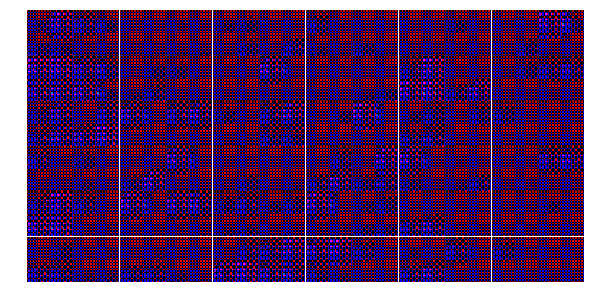

Epoch 3/20... Discriminator Loss: 0.3268... Generator Loss: 6.7218
Epoch 3/20... Discriminator Loss: 0.3268... Generator Loss: 6.7469
Epoch 3/20... Discriminator Loss: 0.3272... Generator Loss: 6.7564
Epoch 3/20... Discriminator Loss: 0.3270... Generator Loss: 6.7618
Epoch 3/20... Discriminator Loss: 0.3272... Generator Loss: 6.7745
Epoch 3/20... Discriminator Loss: 0.3268... Generator Loss: 6.7980
Epoch 4/20... Discriminator Loss: 0.3282... Generator Loss: 6.7010
Epoch 4/20... Discriminator Loss: 0.3272... Generator Loss: 6.6686
Epoch 4/20... Discriminator Loss: 0.3286... Generator Loss: 6.7182
Epoch 4/20... Discriminator Loss: 0.3270... Generator Loss: 6.7419


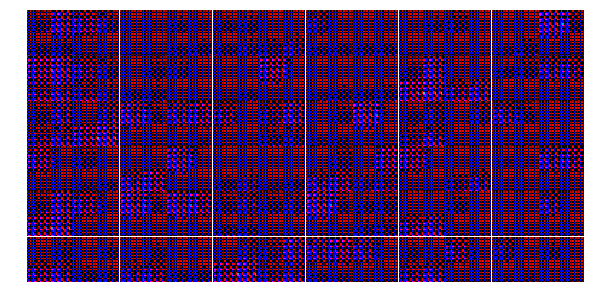

Epoch 4/20... Discriminator Loss: 0.3266... Generator Loss: 6.7750
Epoch 4/20... Discriminator Loss: 0.3282... Generator Loss: 6.7808
Epoch 4/20... Discriminator Loss: 0.3271... Generator Loss: 6.8191
Epoch 4/20... Discriminator Loss: 0.3264... Generator Loss: 6.8498
Epoch 4/20... Discriminator Loss: 0.3265... Generator Loss: 6.8759
Epoch 4/20... Discriminator Loss: 0.3263... Generator Loss: 6.8909
Epoch 4/20... Discriminator Loss: 0.3268... Generator Loss: 6.9376
Epoch 4/20... Discriminator Loss: 0.3267... Generator Loss: 6.9457
Epoch 4/20... Discriminator Loss: 0.3265... Generator Loss: 7.0001
Epoch 4/20... Discriminator Loss: 0.3267... Generator Loss: 6.9902


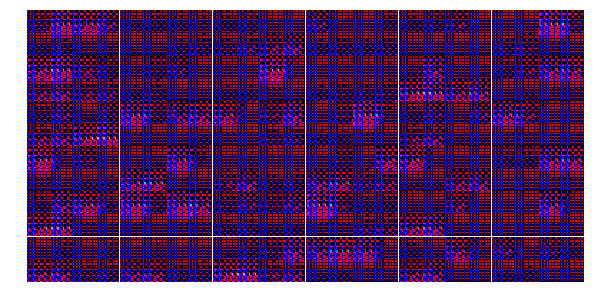

Epoch 4/20... Discriminator Loss: 0.3263... Generator Loss: 7.0516
Epoch 4/20... Discriminator Loss: 0.3264... Generator Loss: 7.0478
Epoch 4/20... Discriminator Loss: 0.3264... Generator Loss: 7.0765
Epoch 4/20... Discriminator Loss: 0.3262... Generator Loss: 7.0909
Epoch 4/20... Discriminator Loss: 0.3269... Generator Loss: 7.0907
Epoch 4/20... Discriminator Loss: 0.3263... Generator Loss: 7.0982
Epoch 4/20... Discriminator Loss: 0.3264... Generator Loss: 7.1135
Epoch 4/20... Discriminator Loss: 0.3263... Generator Loss: 7.1229
Epoch 4/20... Discriminator Loss: 0.3269... Generator Loss: 7.1494
Epoch 4/20... Discriminator Loss: 0.3262... Generator Loss: 7.1491


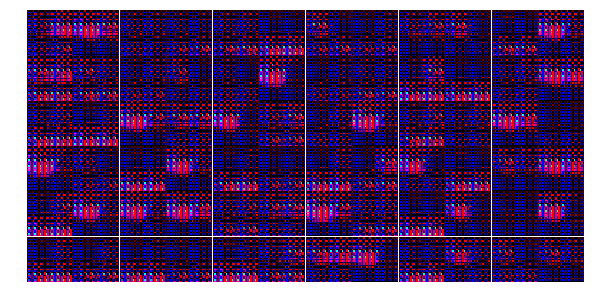

Epoch 4/20... Discriminator Loss: 0.3262... Generator Loss: 7.1505
Epoch 4/20... Discriminator Loss: 0.3267... Generator Loss: 7.1532
Epoch 4/20... Discriminator Loss: 0.3263... Generator Loss: 7.1406
Epoch 4/20... Discriminator Loss: 0.3264... Generator Loss: 7.0742
Epoch 5/20... Discriminator Loss: 0.3267... Generator Loss: 6.8994
Epoch 5/20... Discriminator Loss: 0.3275... Generator Loss: 6.7750
Epoch 5/20... Discriminator Loss: 0.3278... Generator Loss: 6.9112
Epoch 5/20... Discriminator Loss: 0.3269... Generator Loss: 6.9290
Epoch 5/20... Discriminator Loss: 0.3266... Generator Loss: 6.8063
Epoch 5/20... Discriminator Loss: 0.3273... Generator Loss: 6.3745


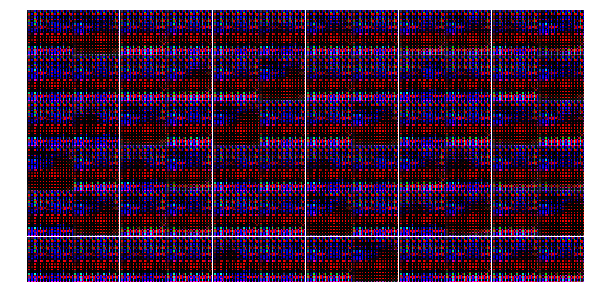

Epoch 5/20... Discriminator Loss: 0.3268... Generator Loss: 6.8067
Epoch 5/20... Discriminator Loss: 0.3271... Generator Loss: 6.6775
Epoch 5/20... Discriminator Loss: 0.3268... Generator Loss: 6.7506
Epoch 5/20... Discriminator Loss: 0.3265... Generator Loss: 6.9530
Epoch 5/20... Discriminator Loss: 0.3270... Generator Loss: 6.9666
Epoch 5/20... Discriminator Loss: 0.3262... Generator Loss: 7.2391
Epoch 5/20... Discriminator Loss: 0.3265... Generator Loss: 7.2511
Epoch 5/20... Discriminator Loss: 0.3263... Generator Loss: 7.2894
Epoch 5/20... Discriminator Loss: 0.3260... Generator Loss: 7.3657
Epoch 5/20... Discriminator Loss: 0.3261... Generator Loss: 7.4348


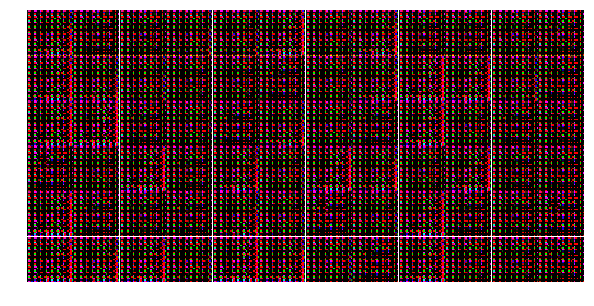

Epoch 5/20... Discriminator Loss: 0.3263... Generator Loss: 7.4595
Epoch 5/20... Discriminator Loss: 0.3259... Generator Loss: 7.5078
Epoch 5/20... Discriminator Loss: 0.3259... Generator Loss: 7.5499
Epoch 5/20... Discriminator Loss: 0.3260... Generator Loss: 7.5556
Epoch 5/20... Discriminator Loss: 0.3259... Generator Loss: 7.5665
Epoch 5/20... Discriminator Loss: 0.3259... Generator Loss: 7.5887
Epoch 5/20... Discriminator Loss: 0.3259... Generator Loss: 7.6053
Epoch 5/20... Discriminator Loss: 0.3258... Generator Loss: 7.6122
Epoch 5/20... Discriminator Loss: 0.3261... Generator Loss: 7.6193
Epoch 5/20... Discriminator Loss: 0.3257... Generator Loss: 7.6173


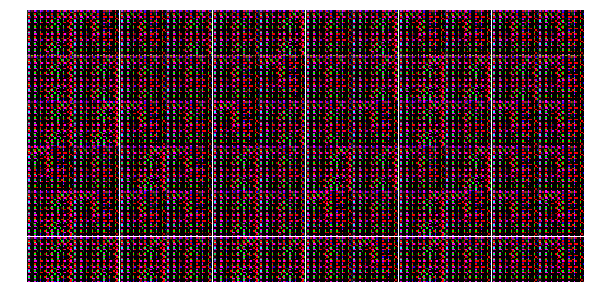

Epoch 5/20... Discriminator Loss: 0.3266... Generator Loss: 7.6407
Epoch 5/20... Discriminator Loss: 0.3265... Generator Loss: 7.6402
Epoch 5/20... Discriminator Loss: 0.3258... Generator Loss: 7.6387
Epoch 6/20... Discriminator Loss: 0.3260... Generator Loss: 7.4843
Epoch 6/20... Discriminator Loss: 0.3288... Generator Loss: 7.5366
Epoch 6/20... Discriminator Loss: 0.3264... Generator Loss: 7.5522
Epoch 6/20... Discriminator Loss: 0.3266... Generator Loss: 7.5564
Epoch 6/20... Discriminator Loss: 0.3258... Generator Loss: 7.5301
Epoch 6/20... Discriminator Loss: 0.3273... Generator Loss: 7.0057
Epoch 6/20... Discriminator Loss: 0.3277... Generator Loss: 6.3065


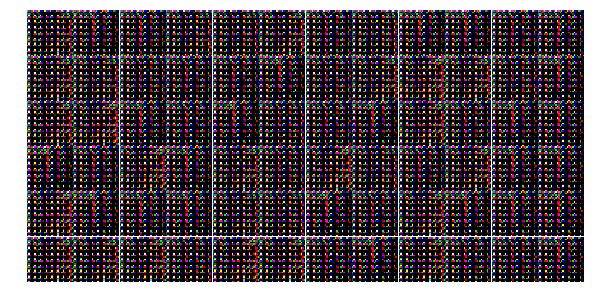

Epoch 6/20... Discriminator Loss: 0.3306... Generator Loss: 6.2955
Epoch 6/20... Discriminator Loss: 0.3270... Generator Loss: 6.8852
Epoch 6/20... Discriminator Loss: 0.3277... Generator Loss: 7.2730
Epoch 6/20... Discriminator Loss: 0.3264... Generator Loss: 7.6557
Epoch 6/20... Discriminator Loss: 0.3267... Generator Loss: 7.5906
Epoch 6/20... Discriminator Loss: 0.3261... Generator Loss: 7.4317
Epoch 6/20... Discriminator Loss: 0.3263... Generator Loss: 7.4580
Epoch 6/20... Discriminator Loss: 0.3268... Generator Loss: 6.7024
Epoch 6/20... Discriminator Loss: 0.3263... Generator Loss: 7.8177
Epoch 6/20... Discriminator Loss: 0.3259... Generator Loss: 7.8862


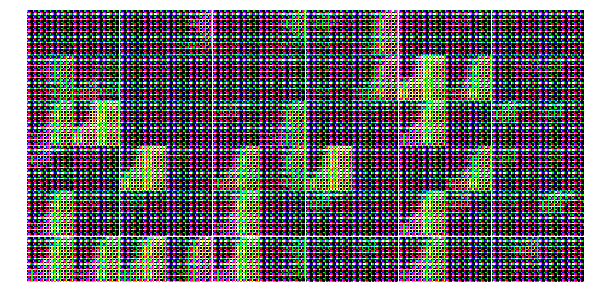

Epoch 6/20... Discriminator Loss: 0.3261... Generator Loss: 7.8809
Epoch 6/20... Discriminator Loss: 0.3262... Generator Loss: 7.8852
Epoch 6/20... Discriminator Loss: 0.3260... Generator Loss: 7.8788
Epoch 6/20... Discriminator Loss: 0.3258... Generator Loss: 7.8821
Epoch 6/20... Discriminator Loss: 0.3261... Generator Loss: 7.7853
Epoch 6/20... Discriminator Loss: 0.3259... Generator Loss: 7.7146
Epoch 6/20... Discriminator Loss: 0.3257... Generator Loss: 7.8253
Epoch 6/20... Discriminator Loss: 0.3258... Generator Loss: 7.8451
Epoch 6/20... Discriminator Loss: 0.3259... Generator Loss: 7.8287
Epoch 6/20... Discriminator Loss: 0.3258... Generator Loss: 7.8801


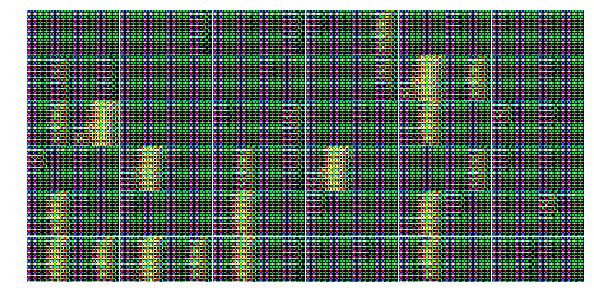

Epoch 6/20... Discriminator Loss: 0.3258... Generator Loss: 7.9134
Epoch 6/20... Discriminator Loss: 0.3259... Generator Loss: 7.9126
Epoch 7/20... Discriminator Loss: 0.3257... Generator Loss: 7.8463
Epoch 7/20... Discriminator Loss: 0.3259... Generator Loss: 7.8252
Epoch 7/20... Discriminator Loss: 0.3261... Generator Loss: 7.8106
Epoch 7/20... Discriminator Loss: 0.3257... Generator Loss: 7.8176
Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.8590
Epoch 7/20... Discriminator Loss: 0.3261... Generator Loss: 7.8183
Epoch 7/20... Discriminator Loss: 0.3257... Generator Loss: 7.7639
Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.7243


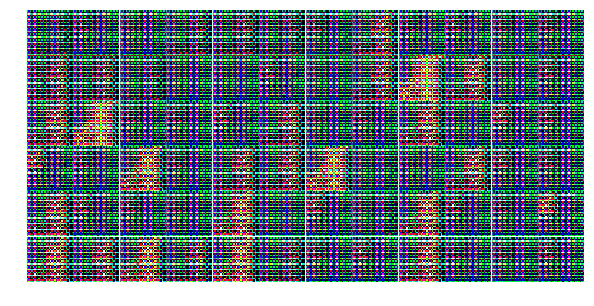

Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.6723
Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.5301
Epoch 7/20... Discriminator Loss: 0.3259... Generator Loss: 7.5416
Epoch 7/20... Discriminator Loss: 0.3259... Generator Loss: 7.5425
Epoch 7/20... Discriminator Loss: 0.3259... Generator Loss: 7.5234
Epoch 7/20... Discriminator Loss: 0.3260... Generator Loss: 7.4270
Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.4778
Epoch 7/20... Discriminator Loss: 0.3258... Generator Loss: 7.6311
Epoch 7/20... Discriminator Loss: 0.3261... Generator Loss: 7.6344
Epoch 7/20... Discriminator Loss: 0.3260... Generator Loss: 7.3159


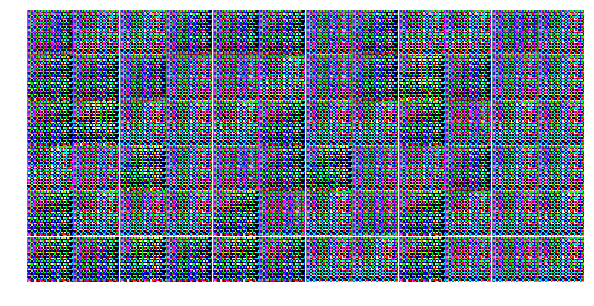

Epoch 7/20... Discriminator Loss: 0.3260... Generator Loss: 7.5453
Epoch 7/20... Discriminator Loss: 0.3266... Generator Loss: 6.9900
Epoch 7/20... Discriminator Loss: 0.3272... Generator Loss: 6.4687
Epoch 7/20... Discriminator Loss: 0.3287... Generator Loss: 6.2056
Epoch 7/20... Discriminator Loss: 0.3271... Generator Loss: 7.3334
Epoch 7/20... Discriminator Loss: 0.3272... Generator Loss: 6.6106
Epoch 7/20... Discriminator Loss: 0.3271... Generator Loss: 6.6192
Epoch 7/20... Discriminator Loss: 0.3287... Generator Loss: 6.0215
Epoch 7/20... Discriminator Loss: 0.3292... Generator Loss: 7.2584
Epoch 7/20... Discriminator Loss: 0.3347... Generator Loss: 6.5134


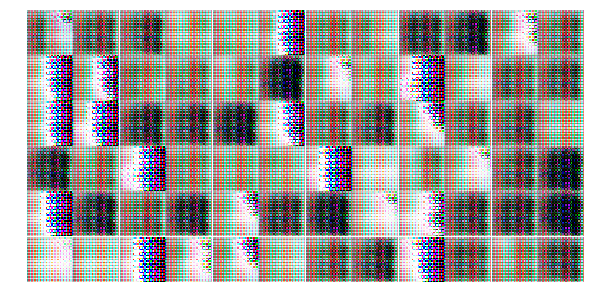

Epoch 8/20... Discriminator Loss: 1.0205... Generator Loss: 3.9242
Epoch 8/20... Discriminator Loss: 0.4049... Generator Loss: 3.0316
Epoch 8/20... Discriminator Loss: 0.3616... Generator Loss: 4.1390
Epoch 8/20... Discriminator Loss: 0.5509... Generator Loss: 2.0165
Epoch 8/20... Discriminator Loss: 0.9911... Generator Loss: 1.4964
Epoch 8/20... Discriminator Loss: 0.7262... Generator Loss: 2.1964
Epoch 8/20... Discriminator Loss: 0.4924... Generator Loss: 3.2032
Epoch 8/20... Discriminator Loss: 0.3740... Generator Loss: 3.7710
Epoch 8/20... Discriminator Loss: 0.3701... Generator Loss: 4.1916
Epoch 8/20... Discriminator Loss: 0.3767... Generator Loss: 3.5760


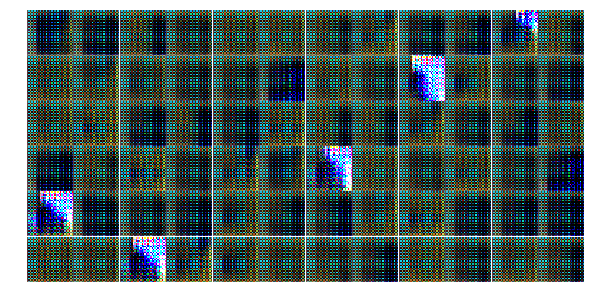

Epoch 8/20... Discriminator Loss: 0.3499... Generator Loss: 5.5422
Epoch 8/20... Discriminator Loss: 0.3542... Generator Loss: 5.8883
Epoch 8/20... Discriminator Loss: 0.3506... Generator Loss: 5.0237
Epoch 8/20... Discriminator Loss: 0.3562... Generator Loss: 5.3229
Epoch 8/20... Discriminator Loss: 0.3427... Generator Loss: 4.8179
Epoch 8/20... Discriminator Loss: 0.3333... Generator Loss: 5.4581
Epoch 8/20... Discriminator Loss: 0.3413... Generator Loss: 5.0207
Epoch 8/20... Discriminator Loss: 0.3338... Generator Loss: 5.4340
Epoch 8/20... Discriminator Loss: 0.3298... Generator Loss: 6.2076
Epoch 8/20... Discriminator Loss: 0.3350... Generator Loss: 6.2445


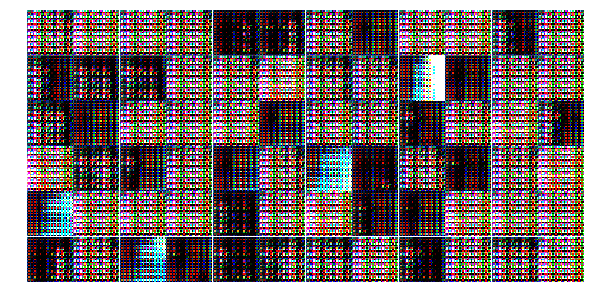

Epoch 8/20... Discriminator Loss: 0.3286... Generator Loss: 6.8773
Epoch 8/20... Discriminator Loss: 0.3352... Generator Loss: 7.0230
Epoch 8/20... Discriminator Loss: 0.3292... Generator Loss: 6.6234
Epoch 8/20... Discriminator Loss: 0.3280... Generator Loss: 6.5420
Epoch 8/20... Discriminator Loss: 0.3459... Generator Loss: 6.5192
Epoch 8/20... Discriminator Loss: 0.3345... Generator Loss: 6.1649
Epoch 8/20... Discriminator Loss: 0.3318... Generator Loss: 5.2882
Epoch 8/20... Discriminator Loss: 0.3312... Generator Loss: 5.4204
Epoch 8/20... Discriminator Loss: 0.3324... Generator Loss: 5.2479
Epoch 9/20... Discriminator Loss: 0.3540... Generator Loss: 4.3293


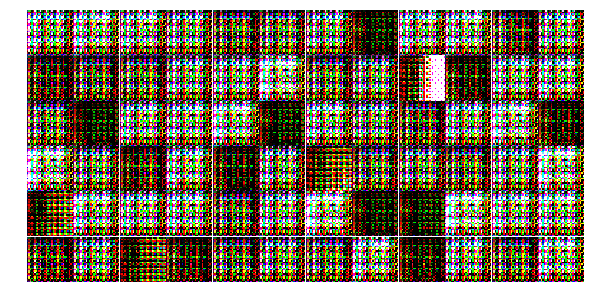

Epoch 9/20... Discriminator Loss: 0.3393... Generator Loss: 5.0198
Epoch 9/20... Discriminator Loss: 0.3382... Generator Loss: 8.1094
Epoch 9/20... Discriminator Loss: 0.3678... Generator Loss: 3.6253
Epoch 9/20... Discriminator Loss: 0.3369... Generator Loss: 5.6454
Epoch 9/20... Discriminator Loss: 0.3360... Generator Loss: 5.1989
Epoch 9/20... Discriminator Loss: 0.3311... Generator Loss: 6.0827
Epoch 9/20... Discriminator Loss: 0.3301... Generator Loss: 7.6181
Epoch 9/20... Discriminator Loss: 0.3289... Generator Loss: 7.6585
Epoch 9/20... Discriminator Loss: 0.3357... Generator Loss: 6.1780
Epoch 9/20... Discriminator Loss: 2.4945... Generator Loss: 1.8472


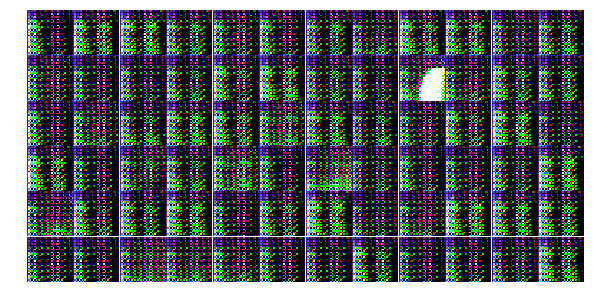

Epoch 9/20... Discriminator Loss: 0.6732... Generator Loss: 1.8706
Epoch 9/20... Discriminator Loss: 1.1566... Generator Loss: 0.7376
Epoch 9/20... Discriminator Loss: 0.5698... Generator Loss: 2.1768
Epoch 9/20... Discriminator Loss: 0.8975... Generator Loss: 1.1004
Epoch 9/20... Discriminator Loss: 0.5949... Generator Loss: 2.0941
Epoch 9/20... Discriminator Loss: 1.3009... Generator Loss: 2.0056
Epoch 9/20... Discriminator Loss: 0.5728... Generator Loss: 1.8419
Epoch 9/20... Discriminator Loss: 0.5068... Generator Loss: 2.1714
Epoch 9/20... Discriminator Loss: 0.5046... Generator Loss: 2.3028
Epoch 9/20... Discriminator Loss: 0.6051... Generator Loss: 2.0084


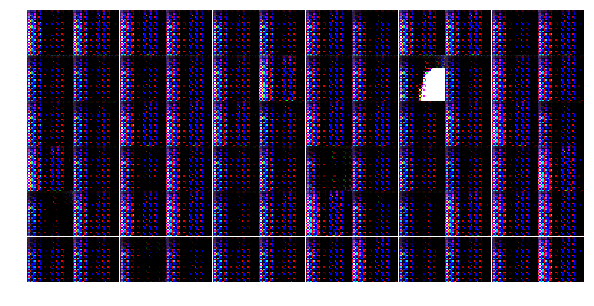

Epoch 9/20... Discriminator Loss: 0.4740... Generator Loss: 2.7382
Epoch 9/20... Discriminator Loss: 0.6285... Generator Loss: 2.5097
Epoch 9/20... Discriminator Loss: 0.5485... Generator Loss: 2.3171
Epoch 9/20... Discriminator Loss: 0.7731... Generator Loss: 1.8087
Epoch 9/20... Discriminator Loss: 0.8995... Generator Loss: 1.3508
Epoch 9/20... Discriminator Loss: 0.4851... Generator Loss: 2.3551
Epoch 9/20... Discriminator Loss: 0.4366... Generator Loss: 3.2435
Epoch 9/20... Discriminator Loss: 0.5215... Generator Loss: 2.6073
Epoch 10/20... Discriminator Loss: 1.3633... Generator Loss: 1.0804
Epoch 10/20... Discriminator Loss: 0.9629... Generator Loss: 1.4322


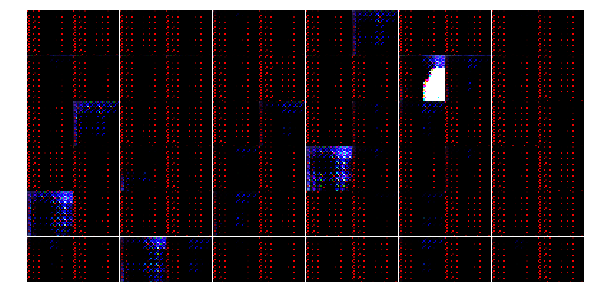

Epoch 10/20... Discriminator Loss: 0.6955... Generator Loss: 1.7404
Epoch 10/20... Discriminator Loss: 0.7548... Generator Loss: 1.6467
Epoch 10/20... Discriminator Loss: 0.9200... Generator Loss: 2.6198
Epoch 10/20... Discriminator Loss: 0.4999... Generator Loss: 2.8655
Epoch 10/20... Discriminator Loss: 0.6470... Generator Loss: 1.7143
Epoch 10/20... Discriminator Loss: 0.4550... Generator Loss: 3.3534
Epoch 10/20... Discriminator Loss: 0.3744... Generator Loss: 4.6248
Epoch 10/20... Discriminator Loss: 0.6170... Generator Loss: 2.6109
Epoch 10/20... Discriminator Loss: 0.6523... Generator Loss: 1.5285
Epoch 10/20... Discriminator Loss: 0.4833... Generator Loss: 4.8856


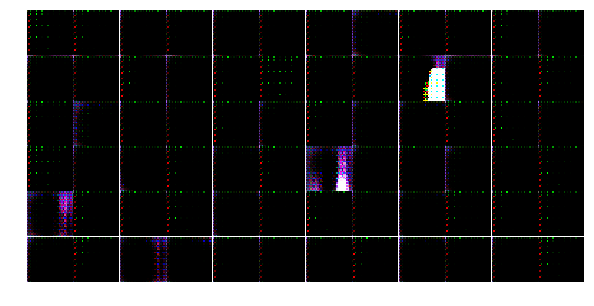

Epoch 10/20... Discriminator Loss: 0.6175... Generator Loss: 2.1449
Epoch 10/20... Discriminator Loss: 0.5055... Generator Loss: 3.9010
Epoch 10/20... Discriminator Loss: 0.3508... Generator Loss: 4.8437
Epoch 10/20... Discriminator Loss: 0.3451... Generator Loss: 5.0795
Epoch 10/20... Discriminator Loss: 0.3419... Generator Loss: 5.3462
Epoch 10/20... Discriminator Loss: 0.3433... Generator Loss: 4.8198
Epoch 10/20... Discriminator Loss: 0.4245... Generator Loss: 3.0629
Epoch 10/20... Discriminator Loss: 0.3808... Generator Loss: 3.2510
Epoch 10/20... Discriminator Loss: 0.7873... Generator Loss: 1.1391
Epoch 10/20... Discriminator Loss: 1.1589... Generator Loss: 0.8641


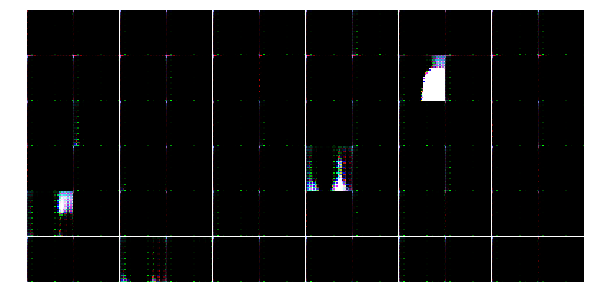

Epoch 10/20... Discriminator Loss: 0.7428... Generator Loss: 1.2933
Epoch 10/20... Discriminator Loss: 0.7687... Generator Loss: 1.2008
Epoch 10/20... Discriminator Loss: 0.6972... Generator Loss: 3.0724
Epoch 10/20... Discriminator Loss: 0.5336... Generator Loss: 2.2485
Epoch 10/20... Discriminator Loss: 0.9650... Generator Loss: 1.2122
Epoch 10/20... Discriminator Loss: 0.6570... Generator Loss: 1.9052
Epoch 10/20... Discriminator Loss: 1.0563... Generator Loss: 2.4764
Epoch 11/20... Discriminator Loss: 0.4569... Generator Loss: 3.3901
Epoch 11/20... Discriminator Loss: 0.5929... Generator Loss: 1.9902
Epoch 11/20... Discriminator Loss: 0.6932... Generator Loss: 1.4156


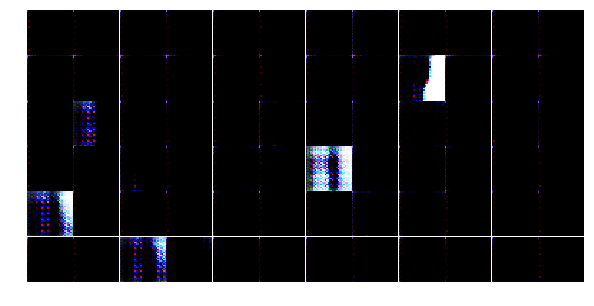

Epoch 11/20... Discriminator Loss: 0.6814... Generator Loss: 2.5305
Epoch 11/20... Discriminator Loss: 0.6744... Generator Loss: 1.4310
Epoch 11/20... Discriminator Loss: 0.8167... Generator Loss: 2.6826
Epoch 11/20... Discriminator Loss: 1.0022... Generator Loss: 1.3459
Epoch 11/20... Discriminator Loss: 0.6511... Generator Loss: 1.6459
Epoch 11/20... Discriminator Loss: 0.6335... Generator Loss: 2.2669
Epoch 11/20... Discriminator Loss: 0.8919... Generator Loss: 2.1202
Epoch 11/20... Discriminator Loss: 0.4789... Generator Loss: 2.6199
Epoch 11/20... Discriminator Loss: 0.5096... Generator Loss: 3.1989
Epoch 11/20... Discriminator Loss: 0.5078... Generator Loss: 2.6236


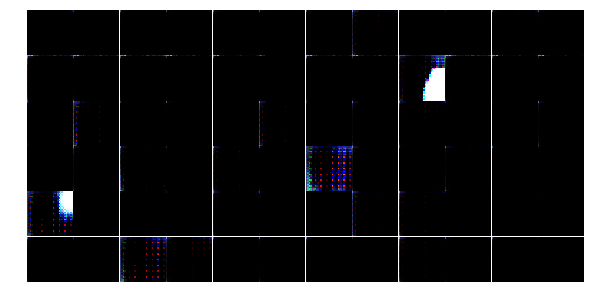

Epoch 11/20... Discriminator Loss: 1.1806... Generator Loss: 0.6399
Epoch 11/20... Discriminator Loss: 0.6032... Generator Loss: 2.1718
Epoch 11/20... Discriminator Loss: 0.6518... Generator Loss: 2.1272
Epoch 11/20... Discriminator Loss: 0.4687... Generator Loss: 2.7577
Epoch 11/20... Discriminator Loss: 0.5549... Generator Loss: 2.4974
Epoch 11/20... Discriminator Loss: 0.5471... Generator Loss: 2.2652
Epoch 11/20... Discriminator Loss: 0.6601... Generator Loss: 1.8370
Epoch 11/20... Discriminator Loss: 0.5540... Generator Loss: 2.2844
Epoch 11/20... Discriminator Loss: 0.8735... Generator Loss: 1.1698
Epoch 11/20... Discriminator Loss: 1.1649... Generator Loss: 1.2042


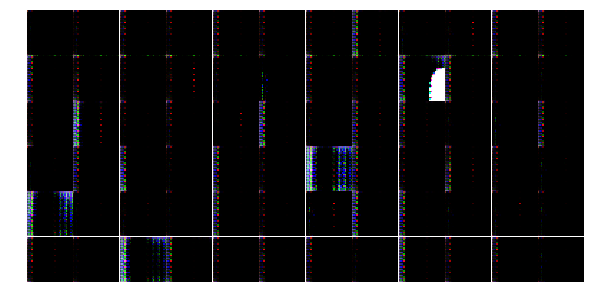

Epoch 11/20... Discriminator Loss: 0.6123... Generator Loss: 2.2683
Epoch 11/20... Discriminator Loss: 0.5274... Generator Loss: 2.4014
Epoch 11/20... Discriminator Loss: 0.8679... Generator Loss: 1.0946
Epoch 11/20... Discriminator Loss: 0.8443... Generator Loss: 1.4206
Epoch 11/20... Discriminator Loss: 0.7286... Generator Loss: 1.4307
Epoch 12/20... Discriminator Loss: 0.7042... Generator Loss: 1.5385
Epoch 12/20... Discriminator Loss: 0.6391... Generator Loss: 1.9884
Epoch 12/20... Discriminator Loss: 0.9055... Generator Loss: 1.8371
Epoch 12/20... Discriminator Loss: 0.6144... Generator Loss: 2.3673
Epoch 12/20... Discriminator Loss: 0.5700... Generator Loss: 2.0716


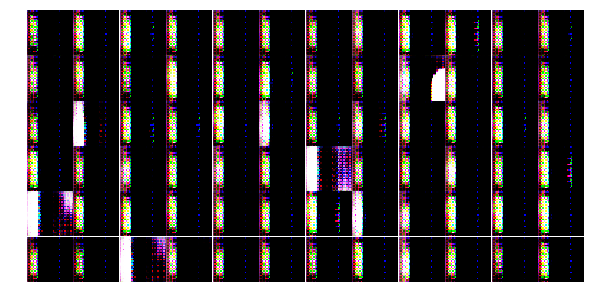

Epoch 12/20... Discriminator Loss: 0.9754... Generator Loss: 1.0791
Epoch 12/20... Discriminator Loss: 0.6728... Generator Loss: 1.8321
Epoch 12/20... Discriminator Loss: 0.4853... Generator Loss: 3.6096
Epoch 12/20... Discriminator Loss: 0.4370... Generator Loss: 3.8230
Epoch 12/20... Discriminator Loss: 0.5894... Generator Loss: 1.8461
Epoch 12/20... Discriminator Loss: 0.5990... Generator Loss: 2.1683
Epoch 12/20... Discriminator Loss: 0.5691... Generator Loss: 1.7846
Epoch 12/20... Discriminator Loss: 0.4525... Generator Loss: 2.8902
Epoch 12/20... Discriminator Loss: 0.6492... Generator Loss: 2.0920
Epoch 12/20... Discriminator Loss: 0.7389... Generator Loss: 1.6232


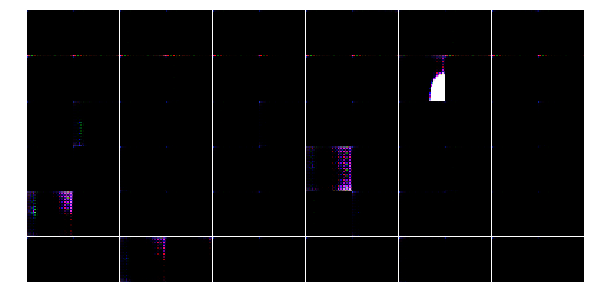

Epoch 12/20... Discriminator Loss: 0.6628... Generator Loss: 2.5090
Epoch 12/20... Discriminator Loss: 0.9269... Generator Loss: 2.4744
Epoch 12/20... Discriminator Loss: 0.4387... Generator Loss: 3.2511
Epoch 12/20... Discriminator Loss: 0.7126... Generator Loss: 1.5087
Epoch 12/20... Discriminator Loss: 0.6375... Generator Loss: 2.1420
Epoch 12/20... Discriminator Loss: 0.4339... Generator Loss: 2.8914
Epoch 12/20... Discriminator Loss: 0.5365... Generator Loss: 2.2070
Epoch 12/20... Discriminator Loss: 0.8460... Generator Loss: 1.1400
Epoch 12/20... Discriminator Loss: 0.4963... Generator Loss: 3.2853
Epoch 12/20... Discriminator Loss: 0.6458... Generator Loss: 2.7434


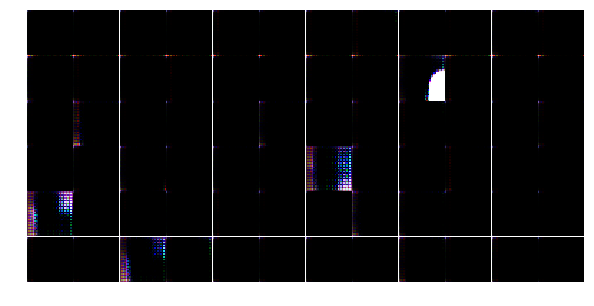

Epoch 12/20... Discriminator Loss: 0.7033... Generator Loss: 2.3406
Epoch 12/20... Discriminator Loss: 0.4826... Generator Loss: 3.6014
Epoch 12/20... Discriminator Loss: 0.4524... Generator Loss: 3.0855
Epoch 12/20... Discriminator Loss: 0.4674... Generator Loss: 2.5820
Epoch 13/20... Discriminator Loss: 0.4867... Generator Loss: 2.5493
Epoch 13/20... Discriminator Loss: 0.7659... Generator Loss: 3.5217
Epoch 13/20... Discriminator Loss: 0.4294... Generator Loss: 3.5024
Epoch 13/20... Discriminator Loss: 0.8333... Generator Loss: 1.4148
Epoch 13/20... Discriminator Loss: 0.4523... Generator Loss: 3.3145
Epoch 13/20... Discriminator Loss: 0.4084... Generator Loss: 4.4185


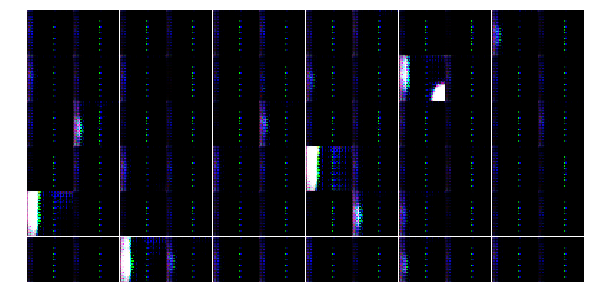

Epoch 13/20... Discriminator Loss: 0.8390... Generator Loss: 1.2095
Epoch 13/20... Discriminator Loss: 0.4190... Generator Loss: 3.6791
Epoch 13/20... Discriminator Loss: 0.3796... Generator Loss: 4.9632
Epoch 13/20... Discriminator Loss: 0.4285... Generator Loss: 3.2711
Epoch 13/20... Discriminator Loss: 0.4901... Generator Loss: 3.6047
Epoch 13/20... Discriminator Loss: 0.5075... Generator Loss: 2.1061
Epoch 13/20... Discriminator Loss: 0.6565... Generator Loss: 1.8176
Epoch 13/20... Discriminator Loss: 0.5894... Generator Loss: 1.8371
Epoch 13/20... Discriminator Loss: 0.5842... Generator Loss: 2.1570
Epoch 13/20... Discriminator Loss: 0.5869... Generator Loss: 2.2541


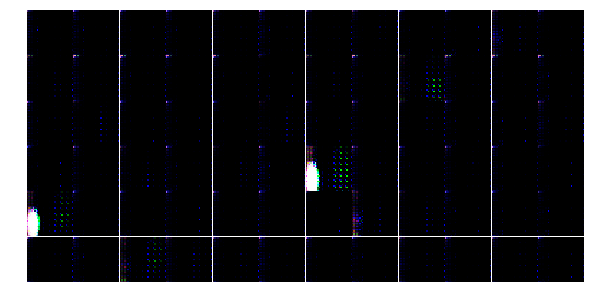

Epoch 13/20... Discriminator Loss: 0.8044... Generator Loss: 1.5945
Epoch 13/20... Discriminator Loss: 0.8070... Generator Loss: 1.1840
Epoch 13/20... Discriminator Loss: 0.3998... Generator Loss: 3.2933
Epoch 13/20... Discriminator Loss: 1.2337... Generator Loss: 0.6145
Epoch 13/20... Discriminator Loss: 0.7292... Generator Loss: 2.6709
Epoch 13/20... Discriminator Loss: 0.5329... Generator Loss: 3.2915
Epoch 13/20... Discriminator Loss: 1.0587... Generator Loss: 0.8609
Epoch 13/20... Discriminator Loss: 0.9140... Generator Loss: 1.6068
Epoch 13/20... Discriminator Loss: 0.8517... Generator Loss: 3.1630
Epoch 13/20... Discriminator Loss: 0.7196... Generator Loss: 3.2544


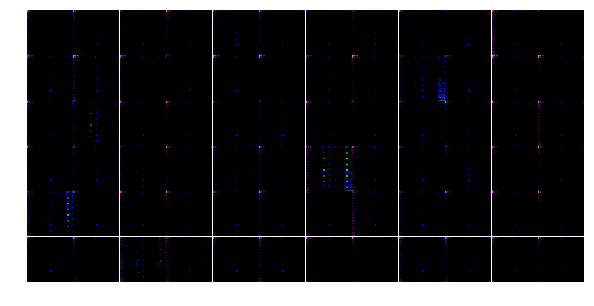

Epoch 13/20... Discriminator Loss: 0.4355... Generator Loss: 2.7843
Epoch 13/20... Discriminator Loss: 0.6367... Generator Loss: 2.3022
Epoch 13/20... Discriminator Loss: 0.8340... Generator Loss: 2.0003
Epoch 14/20... Discriminator Loss: 0.6362... Generator Loss: 2.2216
Epoch 14/20... Discriminator Loss: 0.7564... Generator Loss: 1.7563
Epoch 14/20... Discriminator Loss: 0.9404... Generator Loss: 1.2374
Epoch 14/20... Discriminator Loss: 0.7700... Generator Loss: 1.7888
Epoch 14/20... Discriminator Loss: 0.9323... Generator Loss: 1.4238
Epoch 14/20... Discriminator Loss: 1.1381... Generator Loss: 1.7390
Epoch 14/20... Discriminator Loss: 0.5297... Generator Loss: 2.0679


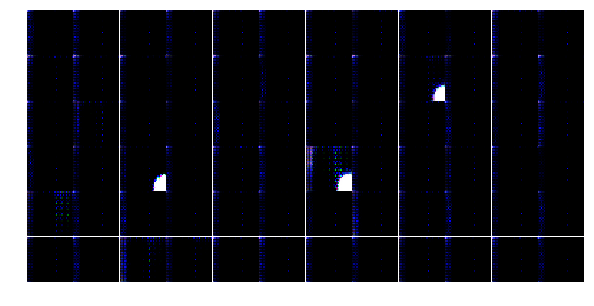

Epoch 14/20... Discriminator Loss: 0.5872... Generator Loss: 2.3214
Epoch 14/20... Discriminator Loss: 0.7042... Generator Loss: 2.4398
Epoch 14/20... Discriminator Loss: 0.6278... Generator Loss: 1.7350
Epoch 14/20... Discriminator Loss: 0.5753... Generator Loss: 1.8138
Epoch 14/20... Discriminator Loss: 0.4284... Generator Loss: 3.1970
Epoch 14/20... Discriminator Loss: 0.4775... Generator Loss: 2.5340
Epoch 14/20... Discriminator Loss: 0.5967... Generator Loss: 1.9375
Epoch 14/20... Discriminator Loss: 0.5439... Generator Loss: 2.0412
Epoch 14/20... Discriminator Loss: 1.1098... Generator Loss: 1.6245
Epoch 14/20... Discriminator Loss: 0.6459... Generator Loss: 1.8242


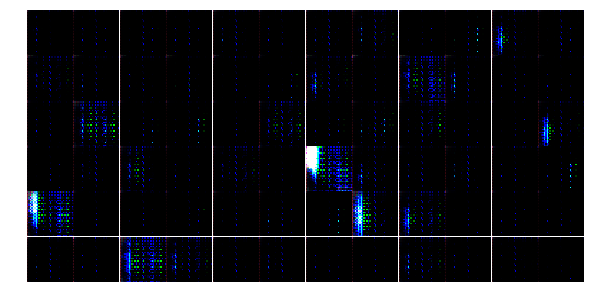

Epoch 14/20... Discriminator Loss: 0.7894... Generator Loss: 1.6380
Epoch 14/20... Discriminator Loss: 0.6406... Generator Loss: 2.0055
Epoch 14/20... Discriminator Loss: 0.8446... Generator Loss: 1.4946
Epoch 14/20... Discriminator Loss: 0.8539... Generator Loss: 1.6022
Epoch 14/20... Discriminator Loss: 0.5540... Generator Loss: 3.3671
Epoch 14/20... Discriminator Loss: 0.5902... Generator Loss: 2.4327
Epoch 14/20... Discriminator Loss: 1.6420... Generator Loss: 0.9518
Epoch 14/20... Discriminator Loss: 0.5199... Generator Loss: 2.2990
Epoch 14/20... Discriminator Loss: 0.5674... Generator Loss: 2.2910
Epoch 14/20... Discriminator Loss: 0.9700... Generator Loss: 1.4665


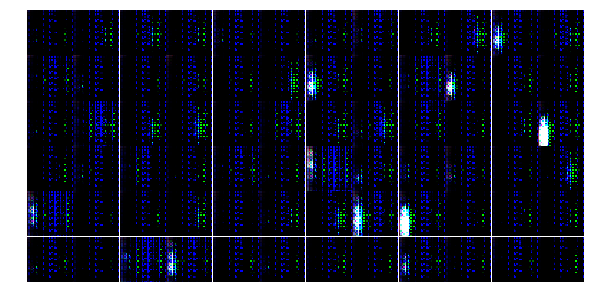

Epoch 14/20... Discriminator Loss: 0.6357... Generator Loss: 1.8963
Epoch 15/20... Discriminator Loss: 0.7315... Generator Loss: 1.3070
Epoch 15/20... Discriminator Loss: 0.8303... Generator Loss: 1.4677
Epoch 15/20... Discriminator Loss: 1.1659... Generator Loss: 1.0649
Epoch 15/20... Discriminator Loss: 0.9548... Generator Loss: 1.2008
Epoch 15/20... Discriminator Loss: 0.7200... Generator Loss: 1.8805
Epoch 15/20... Discriminator Loss: 0.8599... Generator Loss: 1.0682
Epoch 15/20... Discriminator Loss: 1.0566... Generator Loss: 0.8841
Epoch 15/20... Discriminator Loss: 1.0097... Generator Loss: 1.2931
Epoch 15/20... Discriminator Loss: 1.0872... Generator Loss: 0.8902


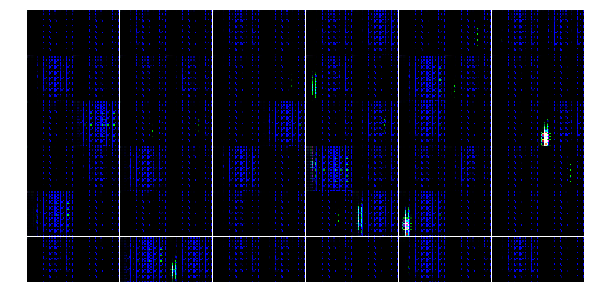

Epoch 15/20... Discriminator Loss: 0.7116... Generator Loss: 1.3690
Epoch 15/20... Discriminator Loss: 0.9137... Generator Loss: 1.8726
Epoch 15/20... Discriminator Loss: 0.7132... Generator Loss: 1.6250
Epoch 15/20... Discriminator Loss: 0.6706... Generator Loss: 1.9991
Epoch 15/20... Discriminator Loss: 1.0346... Generator Loss: 1.1363
Epoch 15/20... Discriminator Loss: 1.0740... Generator Loss: 1.0048
Epoch 15/20... Discriminator Loss: 0.9050... Generator Loss: 1.2980
Epoch 15/20... Discriminator Loss: 0.8239... Generator Loss: 1.6244
Epoch 15/20... Discriminator Loss: 0.8571... Generator Loss: 1.6087
Epoch 15/20... Discriminator Loss: 0.6674... Generator Loss: 1.6534


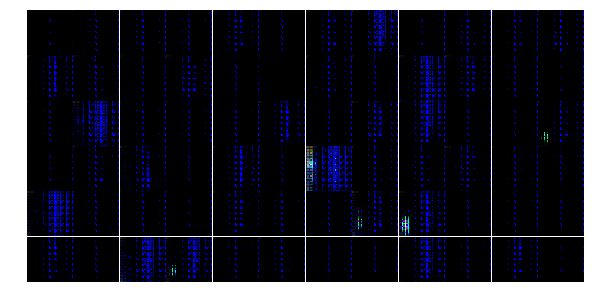

Epoch 15/20... Discriminator Loss: 0.5334... Generator Loss: 2.8420
Epoch 15/20... Discriminator Loss: 0.6543... Generator Loss: 1.6469
Epoch 15/20... Discriminator Loss: 1.0910... Generator Loss: 1.0834
Epoch 15/20... Discriminator Loss: 0.6293... Generator Loss: 2.9427
Epoch 15/20... Discriminator Loss: 0.6206... Generator Loss: 2.3374
Epoch 15/20... Discriminator Loss: 0.6728... Generator Loss: 1.7967
Epoch 15/20... Discriminator Loss: 0.7470... Generator Loss: 1.5058
Epoch 15/20... Discriminator Loss: 1.4398... Generator Loss: 4.1354
Epoch 15/20... Discriminator Loss: 0.6298... Generator Loss: 3.5425
Epoch 15/20... Discriminator Loss: 0.4585... Generator Loss: 2.6251


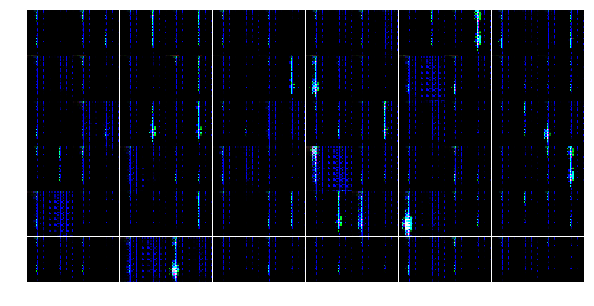

Epoch 16/20... Discriminator Loss: 0.4799... Generator Loss: 2.4266
Epoch 16/20... Discriminator Loss: 0.4197... Generator Loss: 3.1556
Epoch 16/20... Discriminator Loss: 0.5926... Generator Loss: 2.3871
Epoch 16/20... Discriminator Loss: 0.7140... Generator Loss: 1.9497
Epoch 16/20... Discriminator Loss: 0.9066... Generator Loss: 1.6628
Epoch 16/20... Discriminator Loss: 0.7795... Generator Loss: 1.9566
Epoch 16/20... Discriminator Loss: 0.7983... Generator Loss: 2.0651
Epoch 16/20... Discriminator Loss: 0.7346... Generator Loss: 2.3226
Epoch 16/20... Discriminator Loss: 0.7157... Generator Loss: 1.8610
Epoch 16/20... Discriminator Loss: 0.7363... Generator Loss: 2.0803


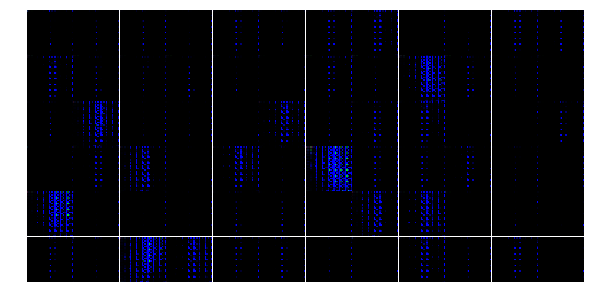

Epoch 16/20... Discriminator Loss: 1.0523... Generator Loss: 2.4891
Epoch 16/20... Discriminator Loss: 0.6617... Generator Loss: 2.2670
Epoch 16/20... Discriminator Loss: 0.4653... Generator Loss: 3.6817
Epoch 16/20... Discriminator Loss: 0.5392... Generator Loss: 2.1269
Epoch 16/20... Discriminator Loss: 0.4515... Generator Loss: 2.6432
Epoch 16/20... Discriminator Loss: 0.4990... Generator Loss: 2.5304
Epoch 16/20... Discriminator Loss: 0.4610... Generator Loss: 2.7868
Epoch 16/20... Discriminator Loss: 0.5462... Generator Loss: 2.1622
Epoch 16/20... Discriminator Loss: 1.0200... Generator Loss: 3.3039
Epoch 16/20... Discriminator Loss: 0.4849... Generator Loss: 2.9807


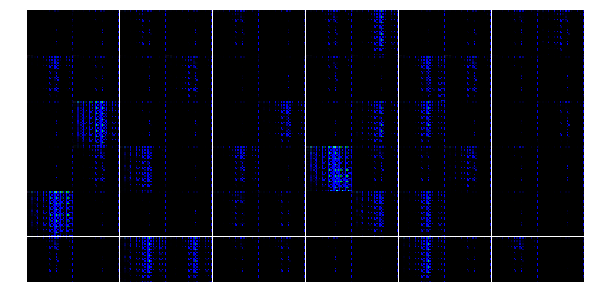

Epoch 16/20... Discriminator Loss: 0.4722... Generator Loss: 2.6382
Epoch 16/20... Discriminator Loss: 0.5060... Generator Loss: 2.9240
Epoch 16/20... Discriminator Loss: 0.4301... Generator Loss: 3.1604
Epoch 16/20... Discriminator Loss: 0.4133... Generator Loss: 3.0577
Epoch 16/20... Discriminator Loss: 0.6067... Generator Loss: 3.7193
Epoch 16/20... Discriminator Loss: 0.6606... Generator Loss: 1.9810
Epoch 16/20... Discriminator Loss: 0.4870... Generator Loss: 2.4556
Epoch 16/20... Discriminator Loss: 0.4431... Generator Loss: 3.0618
Epoch 16/20... Discriminator Loss: 0.7221... Generator Loss: 3.1500
Epoch 17/20... Discriminator Loss: 0.5390... Generator Loss: 2.1484


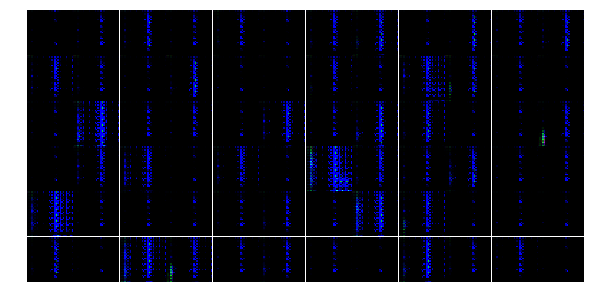

Epoch 17/20... Discriminator Loss: 0.5815... Generator Loss: 1.8025
Epoch 17/20... Discriminator Loss: 0.5597... Generator Loss: 2.0690
Epoch 17/20... Discriminator Loss: 0.7634... Generator Loss: 1.2496
Epoch 17/20... Discriminator Loss: 0.5654... Generator Loss: 1.9344
Epoch 17/20... Discriminator Loss: 0.6045... Generator Loss: 3.0018
Epoch 17/20... Discriminator Loss: 0.6094... Generator Loss: 2.3270
Epoch 17/20... Discriminator Loss: 0.7140... Generator Loss: 2.4416
Epoch 17/20... Discriminator Loss: 0.5105... Generator Loss: 2.3240
Epoch 17/20... Discriminator Loss: 0.8968... Generator Loss: 1.1293
Epoch 17/20... Discriminator Loss: 0.4964... Generator Loss: 2.3935


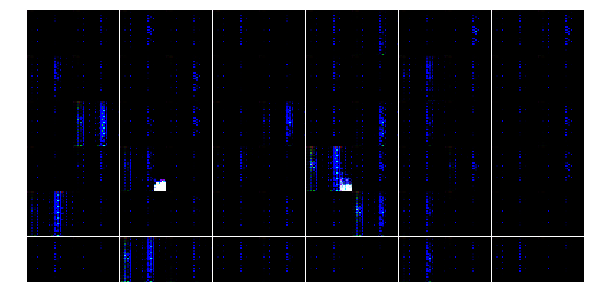

Epoch 17/20... Discriminator Loss: 0.4822... Generator Loss: 2.8478
Epoch 17/20... Discriminator Loss: 0.5357... Generator Loss: 2.1246
Epoch 17/20... Discriminator Loss: 0.7522... Generator Loss: 2.4239
Epoch 17/20... Discriminator Loss: 0.8767... Generator Loss: 2.0691
Epoch 17/20... Discriminator Loss: 0.9114... Generator Loss: 1.6693
Epoch 17/20... Discriminator Loss: 0.7035... Generator Loss: 1.8479
Epoch 17/20... Discriminator Loss: 0.7963... Generator Loss: 1.6587
Epoch 17/20... Discriminator Loss: 0.4733... Generator Loss: 2.6875
Epoch 17/20... Discriminator Loss: 0.4594... Generator Loss: 2.7042
Epoch 17/20... Discriminator Loss: 0.4924... Generator Loss: 2.9927


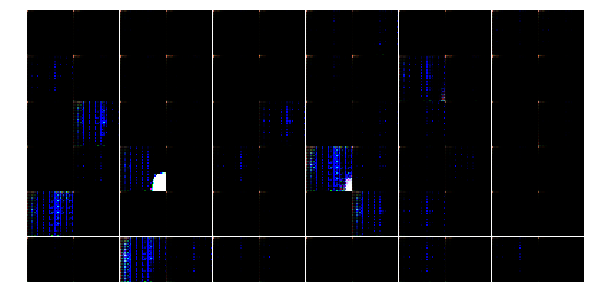

Epoch 17/20... Discriminator Loss: 0.4385... Generator Loss: 3.9247
Epoch 17/20... Discriminator Loss: 0.5247... Generator Loss: 3.2477
Epoch 17/20... Discriminator Loss: 0.4113... Generator Loss: 3.9178
Epoch 17/20... Discriminator Loss: 0.3994... Generator Loss: 3.5720
Epoch 17/20... Discriminator Loss: 0.5275... Generator Loss: 2.7950
Epoch 17/20... Discriminator Loss: 0.3853... Generator Loss: 4.0372
Epoch 17/20... Discriminator Loss: 0.4078... Generator Loss: 3.3029
Epoch 18/20... Discriminator Loss: 0.6128... Generator Loss: 1.8274
Epoch 18/20... Discriminator Loss: 1.1391... Generator Loss: 2.1105
Epoch 18/20... Discriminator Loss: 0.6154... Generator Loss: 1.9689


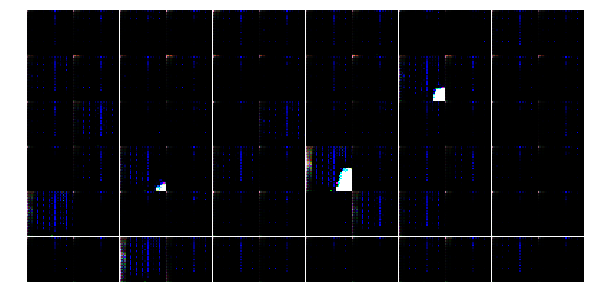

Epoch 18/20... Discriminator Loss: 0.5451... Generator Loss: 2.1588
Epoch 18/20... Discriminator Loss: 0.4972... Generator Loss: 2.4555
Epoch 18/20... Discriminator Loss: 0.8201... Generator Loss: 1.2073
Epoch 18/20... Discriminator Loss: 0.5006... Generator Loss: 2.6785
Epoch 18/20... Discriminator Loss: 1.4518... Generator Loss: 0.9201
Epoch 18/20... Discriminator Loss: 0.6673... Generator Loss: 1.6185
Epoch 18/20... Discriminator Loss: 0.5745... Generator Loss: 2.2883
Epoch 18/20... Discriminator Loss: 0.5439... Generator Loss: 2.1685
Epoch 18/20... Discriminator Loss: 0.9276... Generator Loss: 1.4585
Epoch 18/20... Discriminator Loss: 0.5932... Generator Loss: 1.7934


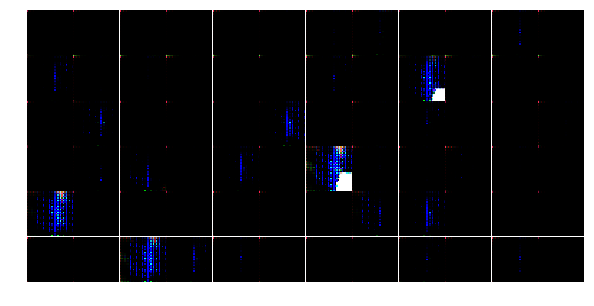

KeyboardInterrupt: 

In [25]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5), writer_dis=writer_discriminator, writer_gen=writer_generator)

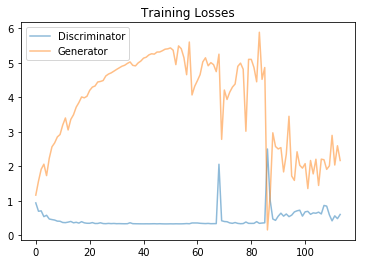

In [26]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


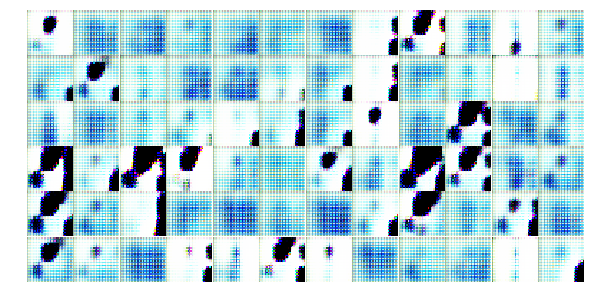

In [27]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))